## Group 3 : Predictive Financial Risk Analytics

## Dimentionality Reduction and Analysis

### Team Memebers
#### Jose George - 9082825
#### Oluwafemi Lawal-
#### Lesley - 




### Importing Libraries and loading the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
%matplotlib inline

# Define dataset path
from pyparsing import Path
import seaborn as sns


Data = Path().resolve() / "data"
file_path = Data / "FraudDetectionDataset.csv"

# Load dataset
df = pd.read_csv(file_path)
df.head()

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Time_of_Transaction,Device_Used,Location,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Payment_Method,Fraudulent
0,T1,4174,1292.76,ATM Withdrawal,16.0,Tablet,San Francisco,0,119,13,Debit Card,0
1,T2,4507,1554.58,ATM Withdrawal,13.0,Mobile,New York,4,79,3,Credit Card,0
2,T3,1860,2395.02,ATM Withdrawal,NaN,Mobile,NaN,3,115,9,NaN,0
3,T4,2294,100.10,Bill Payment,15.0,Desktop,Chicago,4,3,4,UPI,0
4,T5,2130,1490.50,POS Payment,19.0,Mobile,San Francisco,2,57,7,Credit Card,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51000 entries, 0 to 50999
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Transaction_ID                    51000 non-null  object 
 1   User_ID                           51000 non-null  int64  
 2   Transaction_Amount                48480 non-null  float64
 3   Transaction_Type                  51000 non-null  object 
 4   Time_of_Transaction               48448 non-null  float64
 5   Device_Used                       48527 non-null  object 
 6   Location                          48453 non-null  object 
 7   Previous_Fraudulent_Transactions  51000 non-null  int64  
 8   Account_Age                       51000 non-null  int64  
 9   Number_of_Transactions_Last_24H   51000 non-null  int64  
 10  Payment_Method                    48531 non-null  object 
 11  Fraudulent                        51000 non-null  int64  
dtypes: f

### Missing Values Ratio: Identify and remove features with a high percentage of missing values.

In [3]:
# === Missing Values Ratio ===

# Calculate total missing values and ratio for each column
missing_ratio = df.isnull().sum() / len(df)

# Combine with counts for better readability
missing_summary = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Ratio(%)': round(missing_ratio * 100, 2)
}).sort_values(by='Missing_Ratio(%)', ascending=False)

# Display
print("=== Missing Values Summary ===")
print(missing_summary)


=== Missing Values Summary ===
                                  Missing_Count  Missing_Ratio(%)
Time_of_Transaction                        2552              5.00
Location                                   2547              4.99
Transaction_Amount                         2520              4.94
Device_Used                                2473              4.85
Payment_Method                             2469              4.84
Transaction_Type                              0              0.00
Transaction_ID                                0              0.00
User_ID                                       0              0.00
Previous_Fraudulent_Transactions              0              0.00
Account_Age                                   0              0.00
Number_of_Transactions_Last_24H               0              0.00
Fraudulent                                    0              0.00


### Handling Missing Values

| Step | Action                       | Why it Matters for Fraud Analysis                        |
| ---- | ---------------------------- | -------------------------------------------------------- |
| 1    | Compute missing ratio        | Helps decide what’s salvageable                          |
| 2    | Drop columns >30% missing    | Removes unreliable features                              |
| 3    | Drop rows with too many NaNs | Prevents model bias from incomplete samples              |
| 4    | Impute missing values        | Keeps dataset balanced for supervised learning           |
| 5    | Sanity check                 | Confirms clean dataset ready for next preprocessing step |


In [4]:
# === 1. Compute Missing Ratio for Each Feature ===
missing_ratio = df.isnull().mean() * 100

# === 2. Define Threshold ===
# Drop columns if more than 30% values are missing
threshold_col = 30.0

# Keep only columns below the threshold
df_reduced = df.loc[:, missing_ratio < threshold_col]

print(f"Columns retained after dropping those with > {threshold_col}% missing values:")
print(df_reduced.columns.tolist())

# === 3. Optionally drop rows with many missing values (e.g., >50%) ===
threshold_row = 0.5  # means drop rows missing half their data
df_reduced = df_reduced.dropna(thresh=int((1 - threshold_row) * df_reduced.shape[1]))

# === 4. Impute remaining missing values (optional but recommended before ML) ===
# Numeric columns → fill with median
num_cols = df_reduced.select_dtypes(include=['float64', 'int64']).columns
df_reduced[num_cols] = df_reduced[num_cols].fillna(df_reduced[num_cols].median())

# Categorical columns → fill with mode
cat_cols = df_reduced.select_dtypes(include=['object']).columns
df_reduced[cat_cols] = df_reduced[cat_cols].fillna(df_reduced[cat_cols].mode().iloc[0])

# === 5. Final sanity check ===
print("\nMissing values after cleanup:")
print(df_reduced.isnull().sum())


Columns retained after dropping those with > 30.0% missing values:
['Transaction_ID', 'User_ID', 'Transaction_Amount', 'Transaction_Type', 'Time_of_Transaction', 'Device_Used', 'Location', 'Previous_Fraudulent_Transactions', 'Account_Age', 'Number_of_Transactions_Last_24H', 'Payment_Method', 'Fraudulent']

Missing values after cleanup:
Transaction_ID                      0
User_ID                             0
Transaction_Amount                  0
Transaction_Type                    0
Time_of_Transaction                 0
Device_Used                         0
Location                            0
Previous_Fraudulent_Transactions    0
Account_Age                         0
Number_of_Transactions_Last_24H     0
Payment_Method                      0
Fraudulent                          0
dtype: int64


### Low Variance Filter
Appling low variance filter only on numeric predictors (not on ID columns, not directly on raw categorical text).

In [ ]:
from sklearn.feature_selection import VarianceThreshold

# 1) Same numeric feature selection
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cols_to_exclude = ['User_ID', 'Fraudulent']  # Transaction_ID is object so not here
numeric_features = [c for c in numeric_cols if c not in cols_to_exclude]

X_num = df[numeric_features]

# 2) Apply VarianceThreshold
selector = VarianceThreshold(threshold=0.01)  # tweak threshold as needed
X_num_reduced = selector.fit_transform(X_num)

# 3) Get the names of the kept features
kept_feature_mask = selector.get_support()
kept_features = X_num.columns[kept_feature_mask].tolist()

print("Numeric features kept after low variance filtering:")
print(kept_features)

# 4) Build new dataframe with kept numeric features + target
df_lowvar = pd.concat([df[kept_features], df['Fraudulent']], axis=1)

df_lowvar.head()


Numeric features kept after low variance filtering:
['Transaction_Amount', 'Time_of_Transaction', 'Previous_Fraudulent_Transactions', 'Account_Age', 'Number_of_Transactions_Last_24H']


,Transaction_Amount,Time_of_Transaction,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Fraudulent
0,1292.76,16.0,0,119,13,0
1,1554.58,13.0,4,79,3,0
2,2395.02,NaN,3,115,9,0
3,100.10,15.0,4,3,4,0
4,1490.50,19.0,2,57,7,0


### Handling Remaining Missing values by Type

| Type            | Imputation | Reason                                                                                              |
| --------------- | ---------- | --------------------------------------------------------------------------------------------------- |
| **Numeric**     | Median     | Prevents skewing your data when you have large transaction outliers.                                |
| **Categorical** | Mode       | Keeps dominant behavior patterns for categorical predictors like `Payment_Method` or `Device_Used`. |


In [12]:
from sklearn.impute import SimpleImputer

# Separate numeric and categorical columns
num_cols = df_lowvar.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df_lowvar.select_dtypes(include=['object']).columns

# === 1. Numeric Imputation ===
# Replace missing numeric values with median (robust to outliers)
if len(num_cols) > 0:
	num_imputer = SimpleImputer(strategy='median')
	df_lowvar[num_cols] = num_imputer.fit_transform(df_lowvar[num_cols])
else:
	print("No numeric columns to impute.")

# === 2. Categorical Imputation ===
# Replace missing categorical values with mode (most frequent)
# Only run if there are categorical columns; otherwise SimpleImputer raises ValueError
if len(cat_cols) > 0:
	cat_imputer = SimpleImputer(strategy='most_frequent')
	df_lowvar[cat_cols] = cat_imputer.fit_transform(df_lowvar[cat_cols])
else:
	print("No categorical columns to impute.")

# === 3. Sanity Check ===
print("Remaining missing values after imputation:")
print(df_lowvar.isnull().sum())

# assign the cleaned dataframe back to df (do not call the DataFrame as a function)
df = df_lowvar
df.head()

No categorical columns to impute.
Remaining missing values after imputation:
Transaction_Amount                  0
Time_of_Transaction                 0
Previous_Fraudulent_Transactions    0
Account_Age                         0
Number_of_Transactions_Last_24H     0
Fraudulent                          0
dtype: int64


,Transaction_Amount,Time_of_Transaction,Previous_Fraudulent_Transactions,Account_Age,Number_of_Transactions_Last_24H,Fraudulent
0,1292.76,16.0,0.0,119.0,13.0,0.0
1,1554.58,13.0,4.0,79.0,3.0,0.0
2,2395.02,12.0,3.0,115.0,9.0,0.0
3,100.10,15.0,4.0,3.0,4.0,0.0
4,1490.50,19.0,2.0,57.0,7.0,0.0


### Box-Cox Transformation: Normalized skewed numerical features 

Skewness before Box-Cox:
Transaction_Amount                  8.679972
Time_of_Transaction                -0.015837
Previous_Fraudulent_Transactions    0.004440
Account_Age                        -0.002971
Number_of_Transactions_Last_24H     0.005220
dtype: float64
Transaction_Amount transformed with λ = 0.208
Time_of_Transaction transformed with λ = 0.76
Previous_Fraudulent_Transactions transformed with λ = 0.685
Account_Age transformed with λ = 0.718
Number_of_Transactions_Last_24H transformed with λ = 0.724

Skewness after Box-Cox:
Transaction_Amount                  0.257863
Time_of_Transaction                -0.239385
Previous_Fraudulent_Transactions   -0.173758
Account_Age                        -0.276892
Number_of_Transactions_Last_24H    -0.220134
dtype: float64


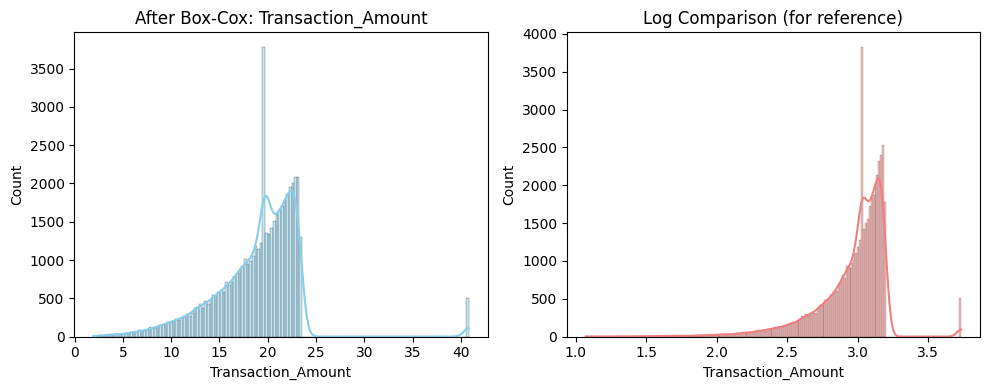

In [14]:
from scipy.stats import boxcox

# === 1. Identify numeric columns ===
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Exclude target and IDs from transformation
exclude_cols = ['User_ID', 'Fraudulent']
num_features = [col for col in numeric_cols if col not in exclude_cols]

# === 2. Check skewness before transformation ===
print("Skewness before Box-Cox:")
print(df[num_features].skew())

# === 3. Apply Box-Cox only on positive columns ===
for col in num_features:
    # Box-Cox requires strictly positive values
    if (df[col] <= 0).any():
        # Shift data if there are zeros or negatives
        df[col] = df[col] - df[col].min() + 1

    # Apply Box–Cox transformation
    df[col], fitted_lambda = boxcox(df[col])
    print(f"{col} transformed with λ = {round(fitted_lambda, 3)}")

# === 4. Check skewness after transformation ===
print("\nSkewness after Box-Cox:")
print(df[num_features].skew())

# === 5. Optional: Visualize before vs after for one example column ===
example_col = num_features[0]  # change if you want another column
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(df[example_col], ax=axes[0], kde=True, color='skyblue')
axes[0].set_title(f"After Box-Cox: {example_col}")

sns.histplot(np.log1p(df[example_col]), ax=axes[1], kde=True, color='lightcoral')
axes[1].set_title(f"Log Comparison (for reference)")
plt.tight_layout()
plt.show()


 Only Transaction_Amount was significantly skewed and therefore most in need of transformation.    

| Feature                              | Skewness | Interpretation                                                                                                          |
| ------------------------------------ | -------- | ----------------------------------------------------------------------------------------------------------------------- |
| **Transaction_Amount**               | **8.68** | Extremely **right-skewed** — meaning most transactions are small, but a few are very large (typical in financial data). |
| **Time_of_Transaction**              | −0.016   | Nearly symmetric (no major skew).                                                                                       |
| **Previous_Fraudulent_Transactions** | 0.004    | Symmetric — no serious distortion.                                                                                      |
| **Account_Age**                      | −0.003   | Symmetric — very low skew.                                                                                              |
| **Number_of_Transactions_Last_24H**  | 0.005    | Symmetric — no major skew.                                                                       


λ (lambda) tells how much transformation was applied:

λ ≈ 1 → almost no change (data was already normal-like).

λ ≈ 0 → strong log-like compression (heavily skewed data).  
              

| Feature                              | λ (Lambda) | Meaning                                                            |
| ------------------------------------ | ---------- | ------------------------------------------------------------------ |
| **Transaction_Amount**               | 0.208      | A strong power transformation — compresses the right tail heavily. |
| **Time_of_Transaction**              | 0.760      | Mild transformation — small adjustment toward normality.           |
| **Previous_Fraudulent_Transactions** | 0.685      | Moderate correction.                                               |
| **Account_Age**                      | 0.718      | Mild normalization.                                                |
| **Number_of_Transactions_Last_24H**  | 0.724      | Mild normalization.                                                |

The transformation successfully normalized all your numeric features, especially the Transaction_Amount, which was highly skewed before.